In [2]:
using GLM
using CSV
using Optim
using Random
using StatsBase
using DataFrames
using Dagitty
using Turing
using StatsPlots
using StatsFuns
using StatisticalRethinking
using StatisticalRethinkingPlots
using Logging
using ProgressBars

default(labels=false)
Logging.disable_logging(Logging.Warn);

# 7.1 The problem with parameters

Code 7.1

In [3]:
sppnames = ["afarensis", "africanus", "habilis", "boisei", "rudolfensis", "ergaster", "sapiens"]
brainvolcc = [438, 452, 612, 521, 752, 871, 1350]
masskg = [37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5]
d = DataFrame(:species => sppnames, :brain => brainvolcc, :mass => masskg);

Code 7.2

In [4]:
d[!,:mass_std] = (d.mass .- mean(d.mass))./std(d.mass)
d[!,:brain_std] = d.brain ./ maximum(d.brain);

Code 7.3

To match results from the book, the model was optimized using MAP estimation, not the MCMC I used before.
The reason for that is the MCMC producing different estimation for log_σ value, which makes all the values 
very different. 

If you want, you can experiment with NUTS sampler for models in 7.1 and 7.2.

In addition, you can also check this discussion: https://github.com/StatisticalRethinkingJulia/StatisticalRethinkingTuring.jl/issues/7

In [5]:
# TODO: move into the Turing package!
import StatsBase: sample
import Turing: ModeResult

function sample(mode_result::ModeResult, count::Int)::DataFrame
    names = coefnames(mode_result)
    means = coef(mode_result)
    sigmas = stderror(mode_result)
    
    DataFrame([
        name => rand(Normal(μ, σ), count)
        for (name, μ, σ) ∈ zip(names, means, sigmas)
    ])
end

sample (generic function with 49 methods)

In [6]:
Random.seed!(1)

@model function model_m7_1(mass_std, brain_std)
    a ~ Normal(0.5, 1)
    b ~ Normal(0, 10)
    μ = @. a + b*mass_std
    log_σ ~ Normal()
    brain_std ~ MvNormal(μ, exp(log_σ))
end

estim = optimize(model_m7_1(d.mass_std, d.brain_std), MAP())
m7_1 = sample(estim, 10000)
precis(m7_1)

┌───────┬─────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%     50%    94.5%     histogram │
├───────┼─────────────────────────────────────────────────────────┤
│     a │  0.5291  0.0689   0.4178  0.5299   0.6367   ▁▁▁▃▆█▇▄▁▁▁ │
│     b │  0.1674  0.0745   0.0481  0.1669   0.2877  ▁▁▁▂▄██▇▄▁▁▁ │
│ log_σ │ -1.7046  0.2938  -2.1821  -1.707  -1.2327   ▁▁▂▄▇█▇▄▂▁▁ │
└───────┴─────────────────────────────────────────────────────────┘


Code 7.4

In [7]:
X = hcat(ones(length(d.mass_std)), d.mass_std)
m = lm(X, d.brain_std)

LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}:

Coefficients:
───────────────────────────────────────────────────────────────
       Coef.  Std. Error     t  Pr(>|t|)   Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────
x1  0.528677   0.0705692  7.49    0.0007   0.347273    0.710081
x2  0.167118   0.0762235  2.19    0.0798  -0.0288204   0.363057
───────────────────────────────────────────────────────────────


Code 7.5

In [8]:
Random.seed!(12)

s = simulate(m7_1, (r, x) -> Normal(r.a + r.b * x, exp(r.log_σ)), d.mass_std)
s = vcat(s'...);

r = mean.(eachcol(s)) .- d.brain_std;
resid_var = var(r, corrected=false)
outcome_var = var(d.brain_std, corrected=false)
1 - resid_var/outcome_var

0.4879524259081207

Code 7.6

In [9]:
# function is implemented in a generic way to support any amount of b[x] coefficients
function R2_is_bad(df; sigma=missing)
    degree = ncol(df[!,r"b"])
    # build mass_std*degree matrix, with each col exponentiated to col's index
    t = repeat(d.mass_std, 1, degree)
    t = hcat(map(.^, eachcol(t), 1:degree)...)
    s = [
        begin
            # calculate product on coefficient's vector
            b = collect(r[r"b"])
            μ = r.a .+ t * b
            s = ismissing(sigma) ? exp(r.log_σ) : sigma
            rand(MvNormal(μ, s))
        end
        for r ∈ eachrow(df)
    ]
    s = vcat(s'...);

    r = mean.(eachcol(s)) .- d.brain_std;
    v1 = var(r, corrected=false)
    v2 = var(d.brain_std, corrected=false)
    1 - v1 / v2
end

R2_is_bad (generic function with 1 method)

Code 7.7

In [10]:
Random.seed!(1)

@model function model_m7_2(mass_std, brain_std)
    a ~ Normal(0.5, 1)
    b ~ MvNormal([0, 0], 10)
    μ = @. a + b[1]*mass_std + b[2]*mass_std^2
    log_σ ~ Normal()
    brain_std ~ MvNormal(μ, exp(log_σ))
end

estim = optimize(model_m7_2(d.mass_std, d.brain_std), MAP())
m7_2 = sample(estim, 10000);

Code 7.8

Implemented the sample in a general way

In [11]:
Random.seed!(1)

@model function model_m7_n(mass_std, brain_std; degree::Int)
    a ~ Normal(0.5, 1)
    b ~ MvNormal(zeros(degree), 10)
    # build matrix n*degree
    t = repeat(mass_std, 1, degree)
    # exponent its columns
    t = hcat(map(.^, eachcol(t), 1:degree)...)
    # calculate product on coefficient's vector
    μ = a .+ t * b
    
    log_σ ~ Normal()
    brain_std ~ MvNormal(μ, exp(log_σ))
end

estim = optimize(model_m7_n(d.mass_std, d.brain_std, degree=3), MAP())
m7_3 = sample(estim, 10000);
estim = optimize(model_m7_n(d.mass_std, d.brain_std, degree=4), MAP())
m7_4 = sample(estim, 10000);
estim = optimize(model_m7_n(d.mass_std, d.brain_std, degree=5), MAP())
m7_5 = sample(estim, 10000);

Code 7.9

In [12]:
Random.seed!(2)

@model function model_m7_6(mass_std, brain_std)
    a ~ Normal(0.5, 1)
    b ~ MvNormal(zeros(6), 10)
    μ = @. a + b[1]*mass_std + b[2]*mass_std^2 + b[3]*mass_std^3 + 
               b[4]*mass_std^4 + b[5]*mass_std^5 + b[6]*mass_std^6 
    brain_std ~ MvNormal(μ, 0.001)
end

estim = optimize(model_m7_6(d.mass_std, d.brain_std), MAP())
m7_6 = sample(estim, 10000);

Code 7.10

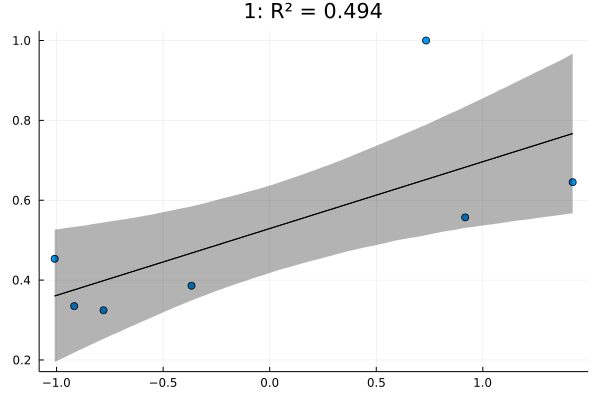

In [13]:
mass_seq = range(extrema(d.mass_std)...; length=100)
l = [
    @. r.a + r.b * mass_seq
    for r ∈ eachrow(m7_1)
]
l = vcat(l'...)
μ = mean.(eachcol(l))
ci = PI.(eachcol(l))
ci = vcat(ci'...)

scatter(d.mass_std, d.brain_std; title="1: R² = $(round(R2_is_bad(m7_1); digits=3))")
plot!(mass_seq, [μ μ]; fillrange=ci, c=:black, fillalpha=0.3)

In [14]:
# reimplemented the brand_plot function to check my results
function brain_plot(df; sigma=missing)
    degree = ncol(df[!,r"b"])
    # build mass_seq*degree matrix, with each col exponentiated to col's index
    t = repeat(mass_seq, 1, degree)
    t = hcat(map(.^, eachcol(t), 1:degree)...)
    l = [
        r.a .+ t * collect(r[r"b"])
        for r ∈ eachrow(df)
    ]
    l = vcat(l'...)
    μ = mean.(eachcol(l))
    ci = PI.(eachcol(l))
    ci = vcat(ci'...)

    r2 = round(R2_is_bad(df, sigma=sigma); digits=3)
    scatter(d.mass_std, d.brain_std; title="$degree: R² = $r2")
    plot!(mass_seq, [μ μ]; fillrange=ci, c=:black, fillalpha=0.3)
end

brain_plot (generic function with 1 method)

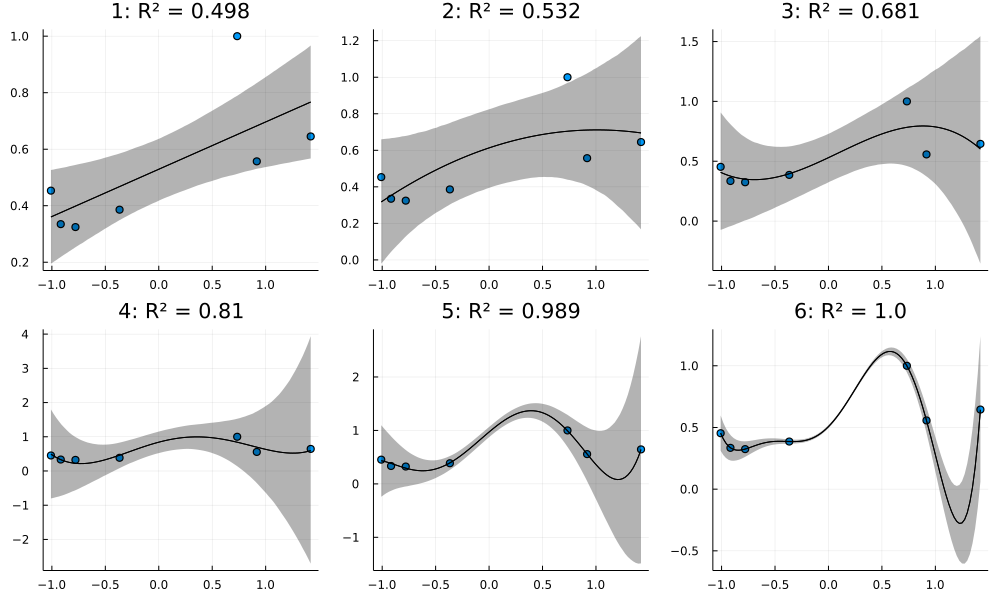

In [15]:
plot(
    brain_plot(m7_1),
    brain_plot(m7_2),
    brain_plot(m7_3),
    brain_plot(m7_4),
    brain_plot(m7_5),
    brain_plot(m7_6, sigma=0.001);
    size=(1000, 600)
)

Code 7.11

In [16]:
i = 3
d_minus_i = d[setdiff(1:end,i),:];

In [17]:
function brain_loo_plot(model, data; title::String)
    (a, b) = extrema(data.brain_std)
    p = scatter(data.mass_std, data.brain_std; title=title, ylim=(a-0.1, b+0.1))
    mass_seq = range(extrema(data.mass_std)...; length=100)
    
    for i ∈ 1:nrow(data)
        d_minus_i = data[setdiff(1:end,i),:]
        df = DataFrame(sample(model(d_minus_i.mass_std, d_minus_i.brain_std), NUTS(), 1000))

        degree = ncol(df[!,r"b"])
        # build mass_seq*degree matrix, with each col exponentiated to col's index
        t = repeat(mass_seq, 1, degree)
        t = hcat(map(.^, eachcol(t), 1:degree)...)
        l = [
            r.a .+ t * collect(r[r"b"])
            for r ∈ eachrow(df)
        ]
        l = vcat(l'...)
        μ = mean.(eachcol(l))
        plot!(mass_seq, μ; c=:black)
    end
    p
end

brain_loo_plot (generic function with 1 method)

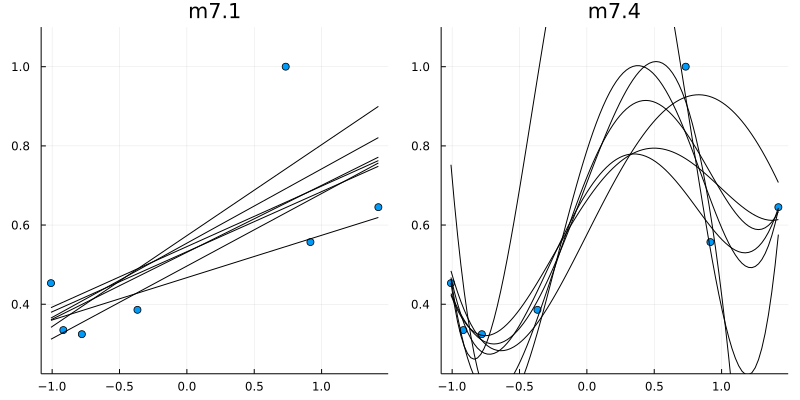

In [18]:
Random.seed!(1)

model_m7_4 = (mass, brain) -> model_m7_n(mass, brain, degree=4)

plot(
    brain_loo_plot(model_m7_1, d, title="m7.1"),
    brain_loo_plot(model_m7_4, d, title="m7.4");
    size=(800, 400)
)

# 7.2 Entropy and accuracy

Code 7.12

In [19]:
p = [0.3, 0.7]
-sum(p .* log.(p))

0.6108643020548935

Code 7.13

In [20]:
lppd(m7_1, (r,x)->Normal(r.a + r.b*x, exp(r.log_σ)), d.mass_std, d.brain_std)

7-element Vector{Float64}:
  0.6075145386066367
  0.6454296289929573
  0.5425588538395871
  0.6201658629011817
  0.45872899947841184
  0.42560250031572444
 -0.8372224151259964

Code 7.14

In [21]:
[
    begin
        s = [
            logpdf(Normal(r.a + r.b * x, exp(r.log_σ)), y)
            for r ∈ eachrow(m7_1)
        ]
        logsumexp(s) - log(length(s))
    end
    for (x, y) ∈ zip(d.mass_std, d.brain_std)
]

7-element Vector{Float64}:
  0.6075145386066367
  0.6454296289929573
  0.5425588538395871
  0.6201658629011817
  0.45872899947841184
  0.42560250031572444
 -0.8372224151259964

Code 7.15

In [22]:
# it could be implemented in a generic way, but I'm too lazy
df_funcs = [
    (m7_1, (r, x) -> Normal(r.a + r.b*x, exp(r.log_σ))),
    (m7_2, (r, x) -> Normal(r.a + r."b[1]" * x + r."b[2]"*x^2, exp(r.log_σ))),
    (m7_3, (r, x) -> Normal(r.a + r."b[1]" * x + r."b[2]"*x^2 + r."b[3]"*x^3, exp(r.log_σ))),
    (m7_4, (r, x) -> Normal(r.a + r."b[1]" * x + r."b[2]"*x^2 + r."b[3]"*x^3 + 
                                  r."b[4]"*x^4, exp(r.log_σ))),
    (m7_5, (r, x) -> Normal(r.a + r."b[1]" * x + r."b[2]"*x^2 + r."b[3]"*x^3 + 
                                  r."b[4]"*x^4 + r."b[5]"*x^5, exp(r.log_σ))),
    (m7_6, (r, x) -> Normal(r.a + r."b[1]" * x + r."b[2]"*x^2 + r."b[3]"*x^3 + 
                                  r."b[4]"*x^4 + r."b[5]"*x^5 + r."b[6]"*x^6, 0.001)),
];

In [23]:
# TODO: spent enormous amount of time on this, but still have no idea why models 2..5 
# are producing different LPPD values in comparison to the book.
# So, if you will find the reason for this, I'll send you a bottle of good Bavarian beer :)
[
    sum(lppd(df, f, d.mass_std, d.brain_std))
    for (df, f) ∈ df_funcs
]

6-element Vector{Float64}:
  2.4627779690085028
  1.468971099667728
  1.0425683863790933
 -3.619430556676747
  2.107407663106212
 13.492902406289048

Code 7.16

In [24]:
@model function m7_sim(x, y; degree::Int=2)
    beta ~ MvNormal(zeros(degree), 1)
    μ = x * beta
    y ~ MvNormal(μ, 1)
end

# Calculate lppd*(-2) from sampled params (b), x matrix and target y values
function get_lppd(m_df, xseq, yseq)
    t = DataFrame(:b => collect(eachrow(Matrix(m_df))))
    -2*sum(lppd(t, (r, x) -> Normal(r.b'*x, 1), eachrow(xseq), yseq))
end

function calc_train_test(N, k; count=100)
    trn_v, tst_v = [], []
    for _ in 1:count
        # method sim_train_test from StatisticalRethinking just simulates the data to be fitted by the model
        y, x_train, x_test = sim_train_test(N=N, K=k)

        estim = optimize(m7_sim(x_train, y, degree=max(2,k)), MAP())
        m7_2 = sample(estim, 1000)
        # commented out is the MCMC way of estimation instead of MAP
#         m_chain = sample(m7_sim(x_train, y, degree=max(2,k)), NUTS(), 1000)
#         m7_2 = DataFrame(m_chain)
        t1 = get_lppd(m7_2, x_train, y)
        t2 = get_lppd(m7_2, x_test, y)
        push!(trn_v, t1)
        push!(tst_v, t2)
    end
    (mean_and_std(trn_v), mean_and_std(tst_v))
end

calc_train_test (generic function with 1 method)

Code 7.17

In [25]:
k_count = 5
k_seq = 1:k_count
count = 100
trn_20, tst_20 = [], []
trn_100, tst_100 = [], []

Threads.@threads for k in k_seq
    println("Processing $k with N=20...")
    t1, t2 = calc_train_test(20, k, count=count)
    push!(trn_20, t1)
    push!(tst_20, t2)
    println("Processing $k with N=100...")
    t1, t2 = calc_train_test(100, k, count=count)
    push!(trn_100, t1)
    push!(tst_100, t2)
end

Processing 1 with N=20...
Processing 3 with N=20...
Processing 4 with N=20...
Processing 5 with N=20...
Processing 5 with N=100...
Processing 4 with N=100...
Processing 3 with N=100...
Processing 1 with N=100...
Processing 2 with N=20...
Processing 2 with N=100...


Code 7.18

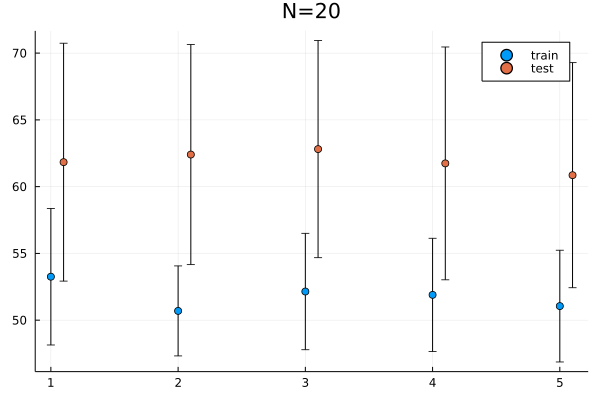

In [26]:
scatter(k_seq, first.(trn_20); yerr=last.(trn_20), label="train", title="N=20")
scatter!(k_seq .+ .1, first.(tst_20); yerr=last.(tst_20), label="test")

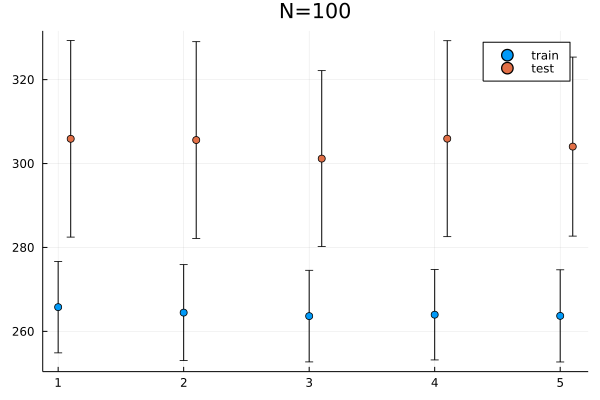

In [27]:
scatter(k_seq, first.(trn_100); yerr=last.(trn_100), label="train", title="N=100")
scatter!(k_seq .+ .1, first.(tst_100); yerr=last.(tst_100), label="test")

Looks like LPPD calculation have issues, which lead to different N=100 chart above and the book.

# 7.3 Golem taming: regularization

No code pieces in this section

# 7.4 Predicting predictive accuracy

Code 7.19

In [28]:
d = DataFrame(CSV.File("data/cars.csv", drop=["Column1"]))

@model function model_m(speed, dist)
    a ~ Normal(0, 100)
    b ~ Normal(0, 10)
    μ = @. a + b * speed 
    σ ~ Exponential(1)
    dist ~ MvNormal(μ, σ)
end

Random.seed!(17)
m_ch = sample(model_m(d.speed, d.dist), NUTS(), 1000)
m_df = DataFrame(m_ch);

Code 7.20

In [29]:
fun = (r, (x, y)) -> normlogpdf(r.a + r.b * x, r.σ, y)
lp = StatisticalRethinking.link(m_df, fun, zip(d.speed, d.dist))
lp = hcat(lp...);

Code 7.21

In [30]:
n_samples, n_cases = size(lp)
lppd_vals = [
    logsumexp(c) - log(n_samples)
    for c in eachcol(lp)
];

## if only lppd were needed, we can calculate it with
# lppd_vals = lppd(m_df, (r, x) -> Normal(r.a + r.b * x, r.σ), d.speed, d.dist)

Code 7.22

In [31]:
pWAIC = [
    var(c)
    for c in eachcol(lp)
];

Code 7.23

In [32]:
-2*(sum(lppd_vals) - sum(pWAIC))

420.44234602973563

Code 7.24

In [33]:
waic_vec = -2*(lppd_vals .- pWAIC)
sqrt(n_cases * var(waic_vec))

15.992120191560327

# 7.5 Model comparison